In [1]:
import geopandas as gpd
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Load data and clean column names
ward_airbnb = gpd.read_file("data/ward_airbnb.gpkg")

In [16]:
# Calculate the 95th quantile for Airbnb density
quantile = np.quantile(ward_airbnb['airbnb_per_1000_household'], 0.95)
print(f"95th quantile: {quantile}")

# Create a high Airbnb density indicator
ward_airbnb['high_airbnb_dens'] = ward_airbnb['airbnb_per_1000_household'] >= quantile

95th quantile: 5.628932432591062


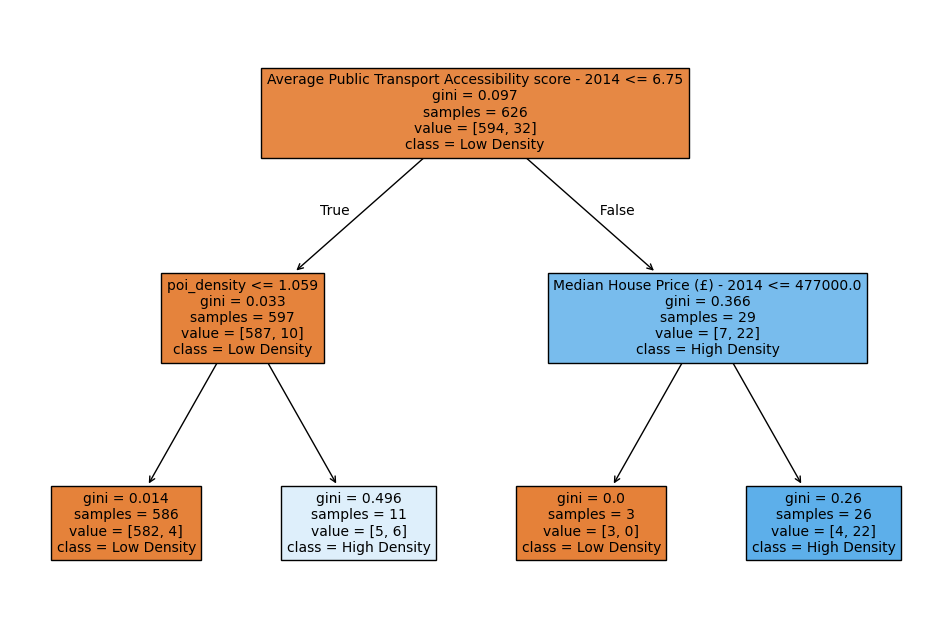

In [24]:
# Prepare data for the decision tree
X = ward_airbnb[['poi_density', 
                 'Average Public Transport Accessibility score - 2014', 
                 'Median House Price (£) - 2014', 
                 'Median Household income estimate (2012/13)']]  # Handle missing values
y = ward_airbnb['high_airbnb_dens']

# Train a decision tree
tree = DecisionTreeClassifier(max_depth=2, random_state=42)
tree.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Low Density', 'High Density'], filled=True, fontsize=10)
plt.show()

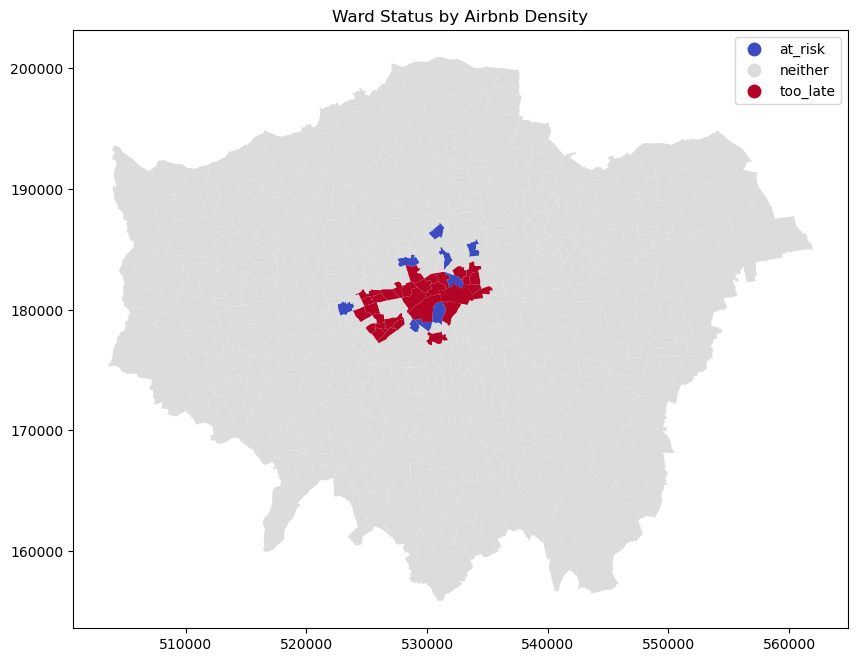

In [25]:
# Add predictions to the GeoDataFrame
ward_airbnb['prediction'] = tree.predict_proba(X)[:, 1] > 0.5

# Generate the at-risk and too-late categories
at_risk = ward_airbnb[(ward_airbnb['high_airbnb_dens'] == False) & (ward_airbnb['prediction'] == True)]
too_late = ward_airbnb[ward_airbnb['high_airbnb_dens'] == True]

ward_airbnb['status'] = 'neither'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(too_late['Ward name']), 'status'] = 'too_late'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(at_risk['Ward name']), 'status'] = 'at_risk'

# Visualise with a choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ward_airbnb.plot(column='status', 
                 legend=True, 
                 cmap='coolwarm', 
                 ax=ax, 
                 legend_kwds={'bbox_to_anchor': (1, 1)})
plt.title("Ward Status by Airbnb Density")
plt.show()

In [29]:
at_risk[['Ward name']]

,Ward name
225,Lambeth - Bishop's
454,Hammersmith and Fulham - Shepherd's Bush Green
483,Westminster - Vincent Square
492,Westminster - Warwick
504,Camden - Camden Town with Primrose Hill
535,Islington - St. Mary's
540,Islington - Bunhill
546,Islington - Finsbury Park
554,Hackney - Dalston
